# Adding Early Stopping to Training Loop

### What is Early Stopping?
Early stopping is a **regularization technique** that helps prevent overfitting during training.  
Instead of training for a fixed number of epochs, we **monitor validation performance** (usually validation loss) and **stop training once the model stops improving**.

---

### How Early Stopping Works
1. **Monitor a Metric**: Track validation loss (or accuracy) at the end of each epoch.  
2. **Define Patience**: If the chosen metric does not improve for a specified number of epochs, stop training early.  
3. **Save Best Weights**: Optionally restore the model to the state where it had the best validation performance.

---

### Benefits
- Prevents **overfitting** by stopping before the model memorizes training data.  
- **Saves compute resources** and reduces training time.  
- Often results in better **generalization** on unseen data.  

---

### Training Loop with Early Stopping
- After each epoch:
  - Compute validation loss.  
  - Compare with the best loss so far.  
  - If improvement → save weights and reset patience counter.  
  - If no improvement → increase patience counter.  
  - Stop training if patience counter exceeds threshold.

---

### Next Steps
In this notebook, we will:
1. Implement a **training loop with validation evaluation**.  
2. Add an **early stopping mechanism**.  
3. Visualize how early stopping affects training compared to fixed-epoch training.


In [1]:
import math, os
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
# 1) Reproducibility & device
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# 2) Toy dataset (two 2D Gaussian blobs)
class BlobsDataset(Dataset):
    def __init__(self, n_per_class=2500, std=1.2):
        # Two Gaussian blobs centered at (-2,-2) and (2,2)
        c0 = np.random.randn(n_per_class, 2) * std + np.array([-2.0, -2.0])
        c1 = np.random.randn(n_per_class, 2) * std + np.array([ 2.0,  2.0])
        X = np.vstack([c0, c1]).astype(np.float32)
        y = np.concatenate([np.zeros(n_per_class), np.ones(n_per_class)]).astype(np.float32)

        # Shuffle
        idx = np.random.permutation(len(X))
        self.X = torch.from_numpy(X[idx])
        self.y = torch.from_numpy(y[idx]).unsqueeze(1)  # (N,1) for BCEWithLogitsLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

dataset = BlobsDataset(n_per_class=2500, std=1.2)

# Train/val split (80/20)
n_total = len(dataset)
n_train = int(n_total * 0.8)
n_val = n_total - n_train
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_set,   batch_size=256, shuffle=False, drop_last=False)

In [4]:
# 3) Model
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)  # logits for binary classification
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# 4) Evaluation helper
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    return total_loss / total, correct / total

### 🛑 EarlyStopping Utility

To prevent **overfitting** and reduce unnecessary training, we implement an **EarlyStopping** class.  
This utility monitors the **validation loss** during training and stops the loop once performance no longer improves.

**Key ideas:**
- **Patience**: Number of epochs to wait after no improvement before stopping.  
- **min_delta**: Minimum improvement in validation loss required to reset the patience counter.  
- **Checkpointing**: The model weights from the epoch with the best validation loss are saved to disk (`ckpt_path`).  

**Workflow:**
1. After each validation step, call `early_stopper.step(val_loss, epoch, model)`.  
2. If the validation loss improves, the best weights are saved and patience counter resets.  
3. If no improvement for `patience` epochs, training stops early.  
4. After training, restore the model from the saved best weights for final evaluation.  

This ensures we keep the **best-performing model** without over-training.


In [6]:
# 5) EarlyStopping utility
class EarlyStopping:
    """
    Stops training when val_loss hasn't improved for `patience` epochs
    by at least `min_delta`. Saves the best model to `ckpt_path`.
    """
    def __init__(self, patience=10, min_delta=1e-4, ckpt_path="/mnt/data/best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.best = math.inf
        self.num_bad_epochs = 0
        self.best_epoch = -1
        self.ckpt_path = ckpt_path

    def step(self, val_loss, epoch, model):
        improved = val_loss < (self.best - self.min_delta)
        if improved:
            self.best = val_loss
            self.num_bad_epochs = 0
            self.best_epoch = epoch
            # Save best weights
            Path(os.path.dirname(self.ckpt_path)).mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), self.ckpt_path)
        else:
            self.num_bad_epochs += 1
        # Return True if we should stop
        return self.num_bad_epochs > self.patience

In [7]:
# 6) Train loop with Early Stopping
num_epochs = 200
early_stopper = EarlyStopping(patience=10, min_delta=1e-4, ckpt_path="checkpoints/best_model.pth")

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, num_epochs + 1):
    # Train phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    # Log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Early stopping check
    stop = early_stopper.step(val_loss, epoch, model)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.4f} | "
          f"Bad {early_stopper.num_bad_epochs}/{early_stopper.patience}")

    if stop:
        print(f"\nEarly stopping at epoch {epoch}. "
              f"Best epoch = {early_stopper.best_epoch}, "
              f"best val loss = {early_stopper.best:.4f}")
        break

Epoch 001 | Train Loss 0.2787 Acc 0.9848 | Val Loss 0.0880 Acc 0.9920 | Bad 0/10
Epoch 002 | Train Loss 0.0567 Acc 0.9905 | Val Loss 0.0330 Acc 0.9930 | Bad 0/10
Epoch 003 | Train Loss 0.0324 Acc 0.9910 | Val Loss 0.0262 Acc 0.9930 | Bad 0/10
Epoch 004 | Train Loss 0.0278 Acc 0.9920 | Val Loss 0.0237 Acc 0.9930 | Bad 0/10
Epoch 005 | Train Loss 0.0262 Acc 0.9910 | Val Loss 0.0222 Acc 0.9920 | Bad 0/10
Epoch 006 | Train Loss 0.0254 Acc 0.9910 | Val Loss 0.0223 Acc 0.9920 | Bad 1/10
Epoch 007 | Train Loss 0.0251 Acc 0.9905 | Val Loss 0.0218 Acc 0.9920 | Bad 0/10
Epoch 008 | Train Loss 0.0248 Acc 0.9908 | Val Loss 0.0221 Acc 0.9920 | Bad 1/10
Epoch 009 | Train Loss 0.0246 Acc 0.9910 | Val Loss 0.0217 Acc 0.9920 | Bad 0/10
Epoch 010 | Train Loss 0.0245 Acc 0.9910 | Val Loss 0.0222 Acc 0.9920 | Bad 1/10
Epoch 011 | Train Loss 0.0244 Acc 0.9908 | Val Loss 0.0222 Acc 0.9920 | Bad 2/10
Epoch 012 | Train Loss 0.0244 Acc 0.9910 | Val Loss 0.0224 Acc 0.9920 | Bad 3/10
Epoch 013 | Train Loss 0.024

In [8]:
# 7) Restore best weights & final eval
ckpt_path = "/mnt/data/best_model.pth"
if os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"\nRestored best weights from: {ckpt_path}")

best_val_loss, best_val_acc = evaluate(model, val_loader, criterion)
print(f"Final (best) -> Val Loss: {best_val_loss:.4f} | Val Acc: {best_val_acc:.4f}")

Final (best) -> Val Loss: 0.0218 | Val Acc: 0.9920


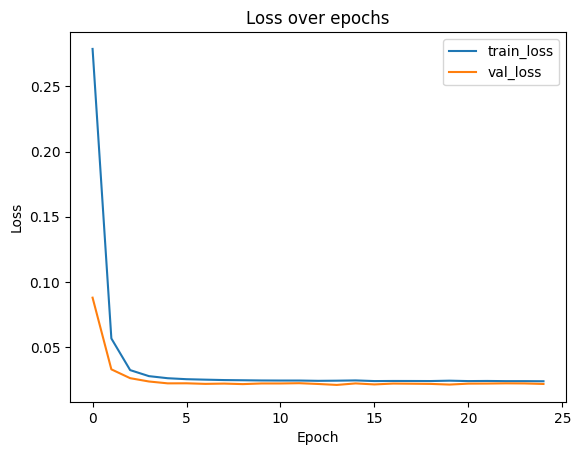

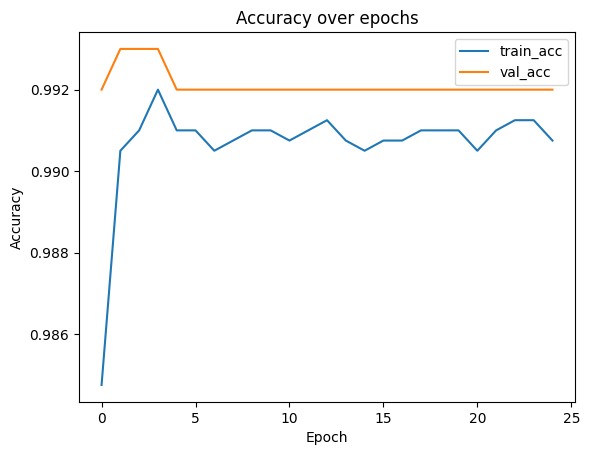

Best checkpoint saved at: /mnt/data/best_model.pth


In [9]:
# 8) Plot curves
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

print("Best checkpoint saved at:", ckpt_path)